In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
class_name = 'TRACK_genre_top_num'
df = pd.read_csv('flat_df_no_nulli_no_out.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli
#df['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df["TRACK_genre_top"]]

df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contrastskew,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,-1.189231,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,-0.977936,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,-0.770891,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,-0.205249,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,-0.328223,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.168924,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.376255,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.339166,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.009937,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America


In [3]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop',
    'ALBUM_type_',
    'track_id'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

<AxesSubplot:>

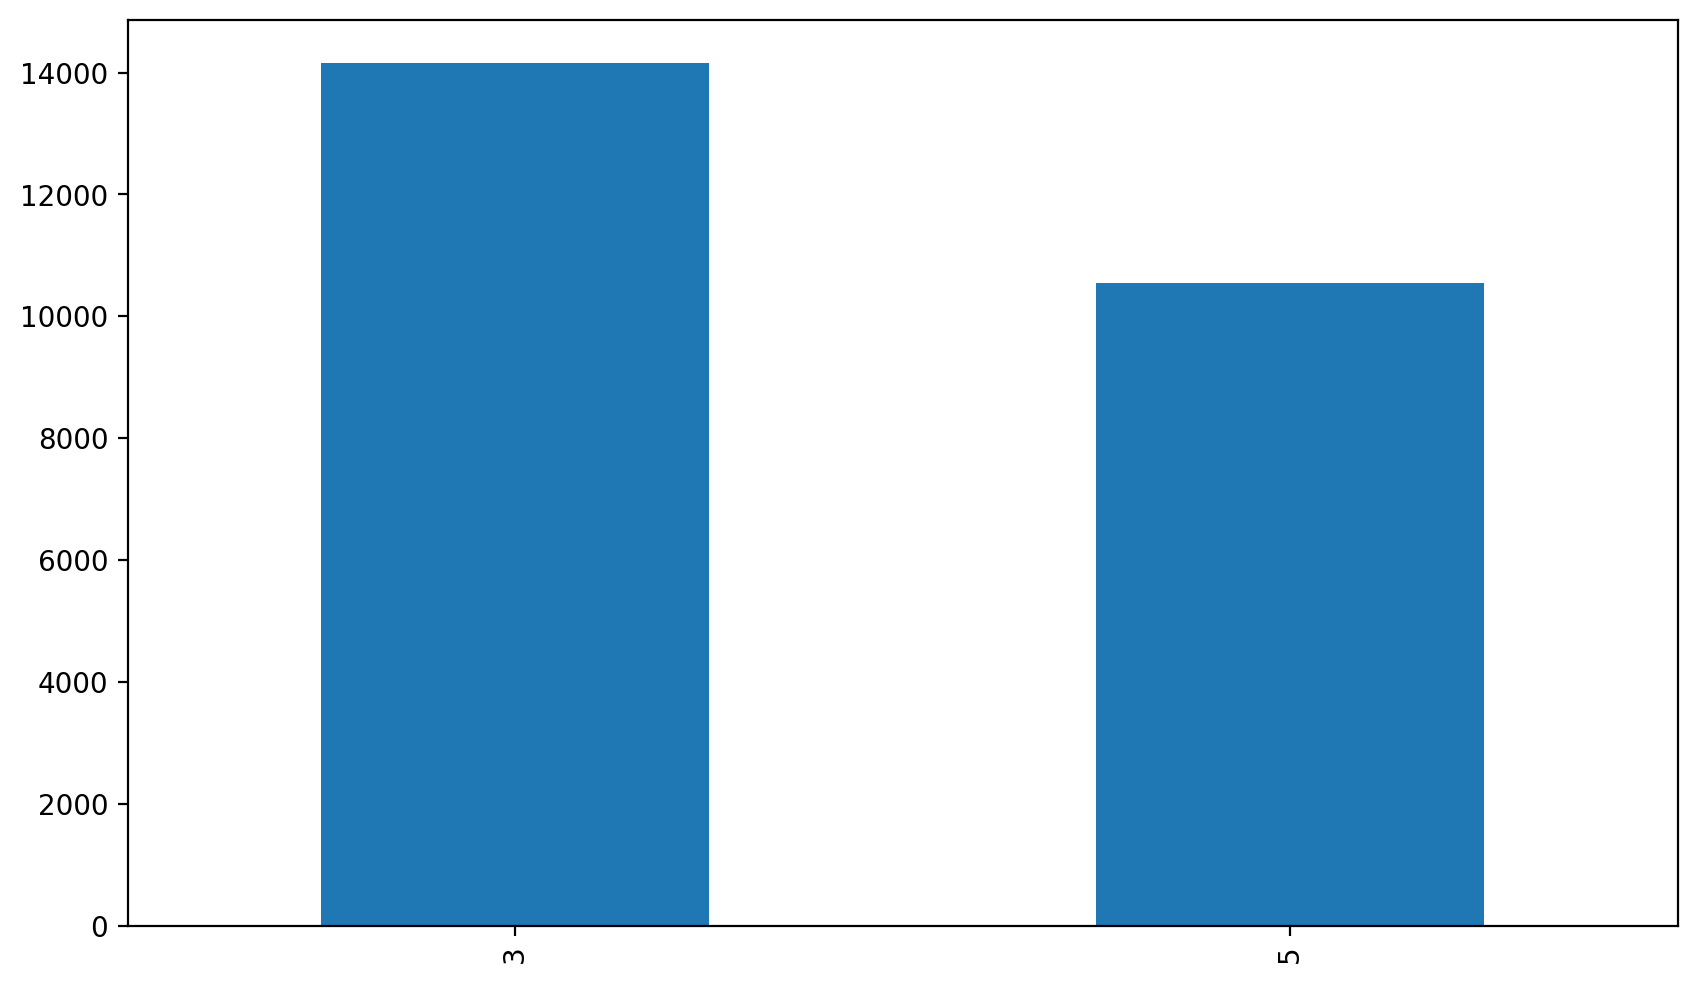

In [4]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2


df['TRACK_genre_top_num']=[-1 if (genre != 5) & (genre != 3) else genre for genre in df['TRACK_genre_top_num']]

df = df[df.TRACK_genre_top_num != -1] #droppo i nulli


plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [5]:
compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [6]:
attributi = [
    "mfccskew",
    "mfccmedian",
    #"ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

X = df[attributi].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
y = df[class_name]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [10]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_scaled, y)

In [11]:
unique, counts = np.unique(y_rus, return_counts=True)


np.asarray((unique, counts))

array([[    3,     5],
       [10544, 10544]], dtype=int64)

In [12]:
unique, counts = np.unique(y, return_counts=True)


np.asarray((unique, counts))

array([[    3,     5],
       [14155, 10544]], dtype=int64)

<AxesSubplot:title={'center':' '}, xlabel='k', ylabel='distortion score'>

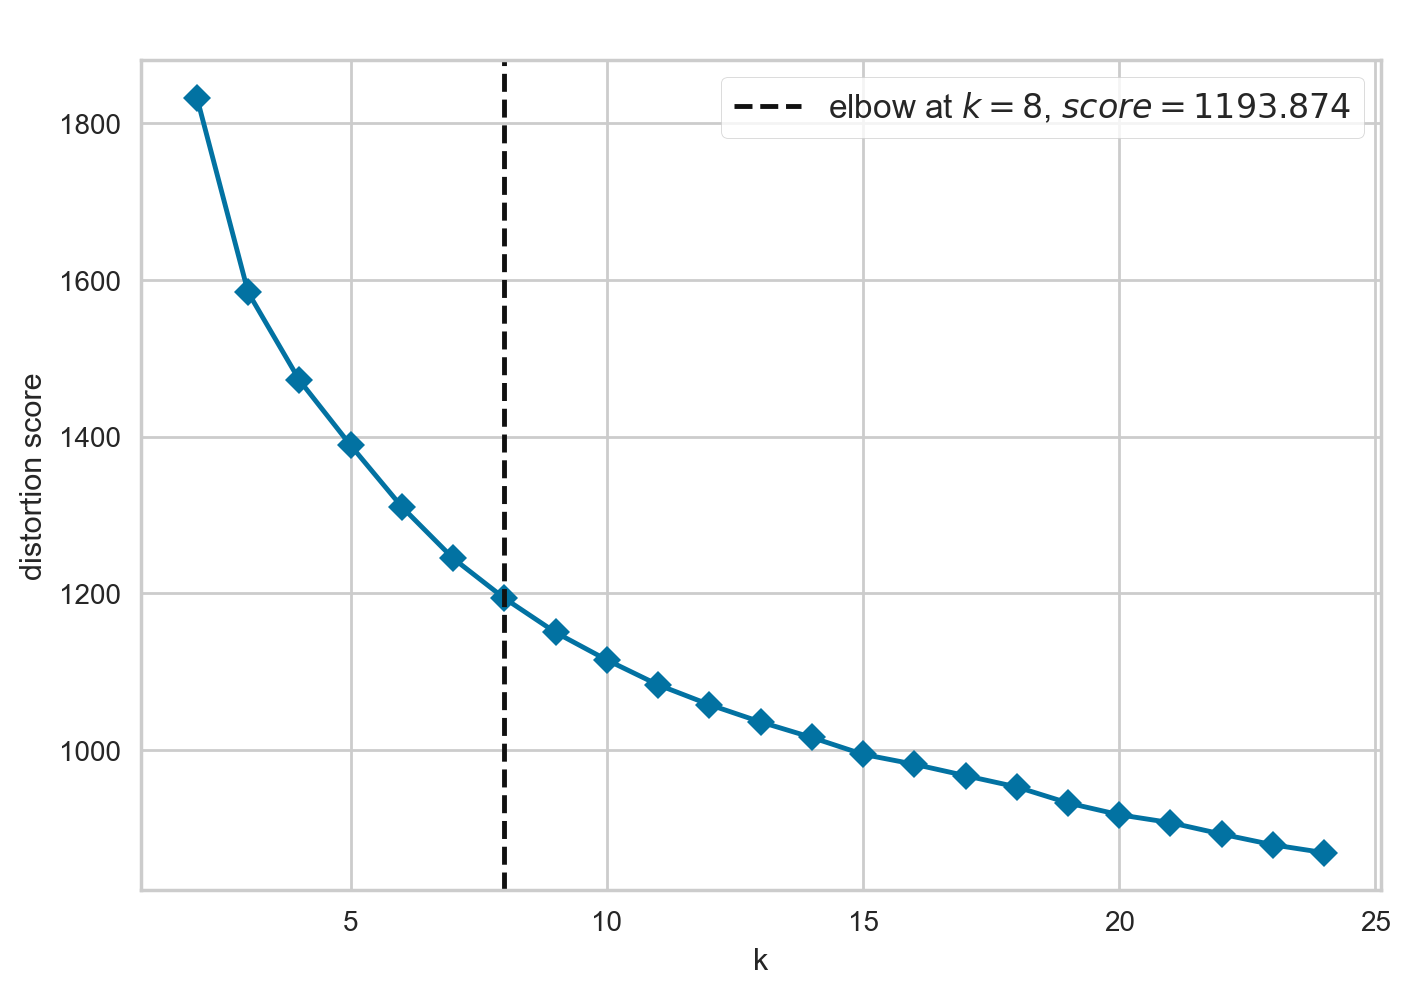

In [98]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_scaled.squeeze())
visualizer.show(outpath="kelbow_KMeans_SSE.png")

<AxesSubplot:title={'center':' '}, xlabel='k', ylabel='silhouette score'>

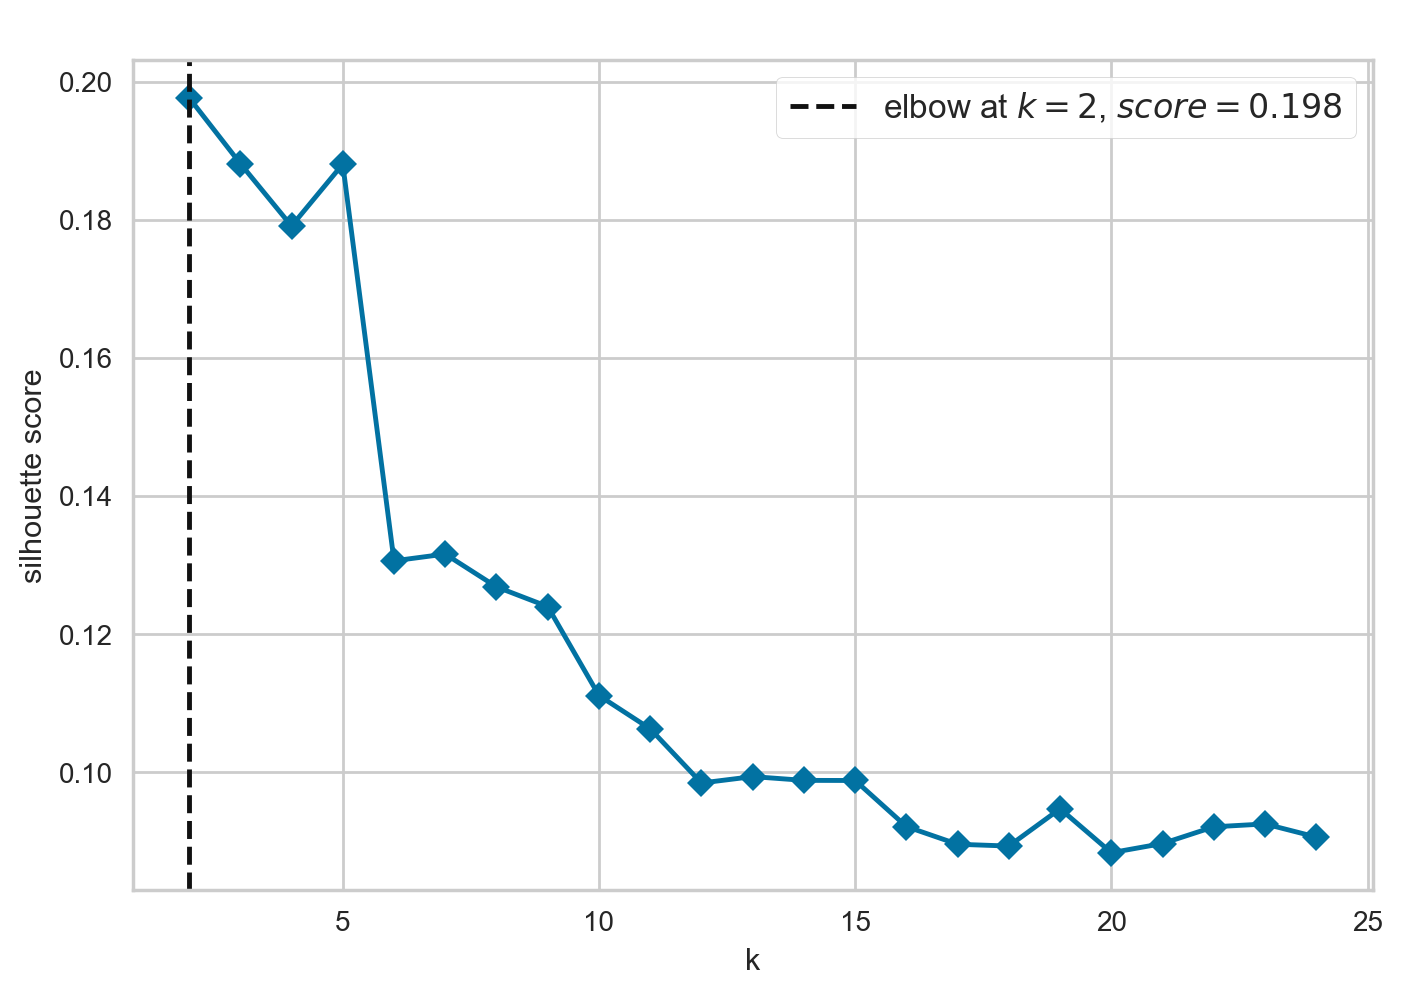

In [99]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ", metric="silhouette")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_scaled.squeeze())
visualizer.show(outpath="kelbow_KMeans_sil.png")

In [132]:
model = KMeans(n_clusters=6)
model.fit(X_scaled)

df['kmeans'] = model.labels_


In [133]:
xlabels = []

for idx, i in enumerate(list(df.groupby('kmeans').size())):
    xlabels.append("Cluster "+ str(idx)+"\n("+str(i)+")")
    
xlabels

['Cluster 0\n(8487)',
 'Cluster 1\n(3725)',
 'Cluster 2\n(1147)',
 'Cluster 3\n(5332)',
 'Cluster 4\n(4077)',
 'Cluster 5\n(1931)']

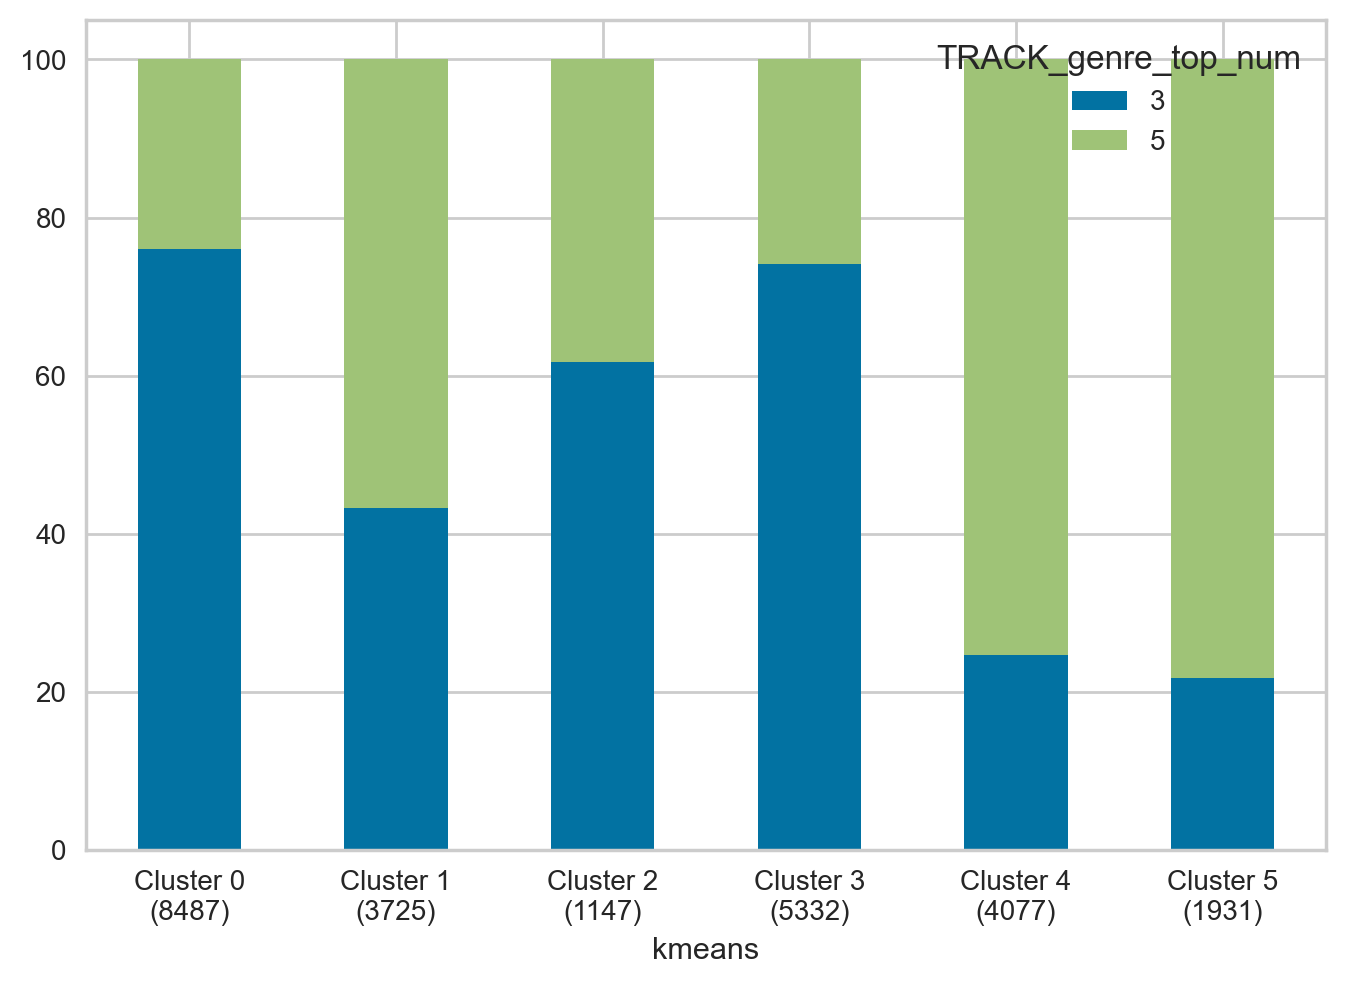

In [134]:
df.groupby(['kmeans',class_name]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.xticks(range(len(xlabels)), xlabels, rotation=0)

plt.savefig("kmeans_cluster_perc.pdf", bbox_inches="tight")

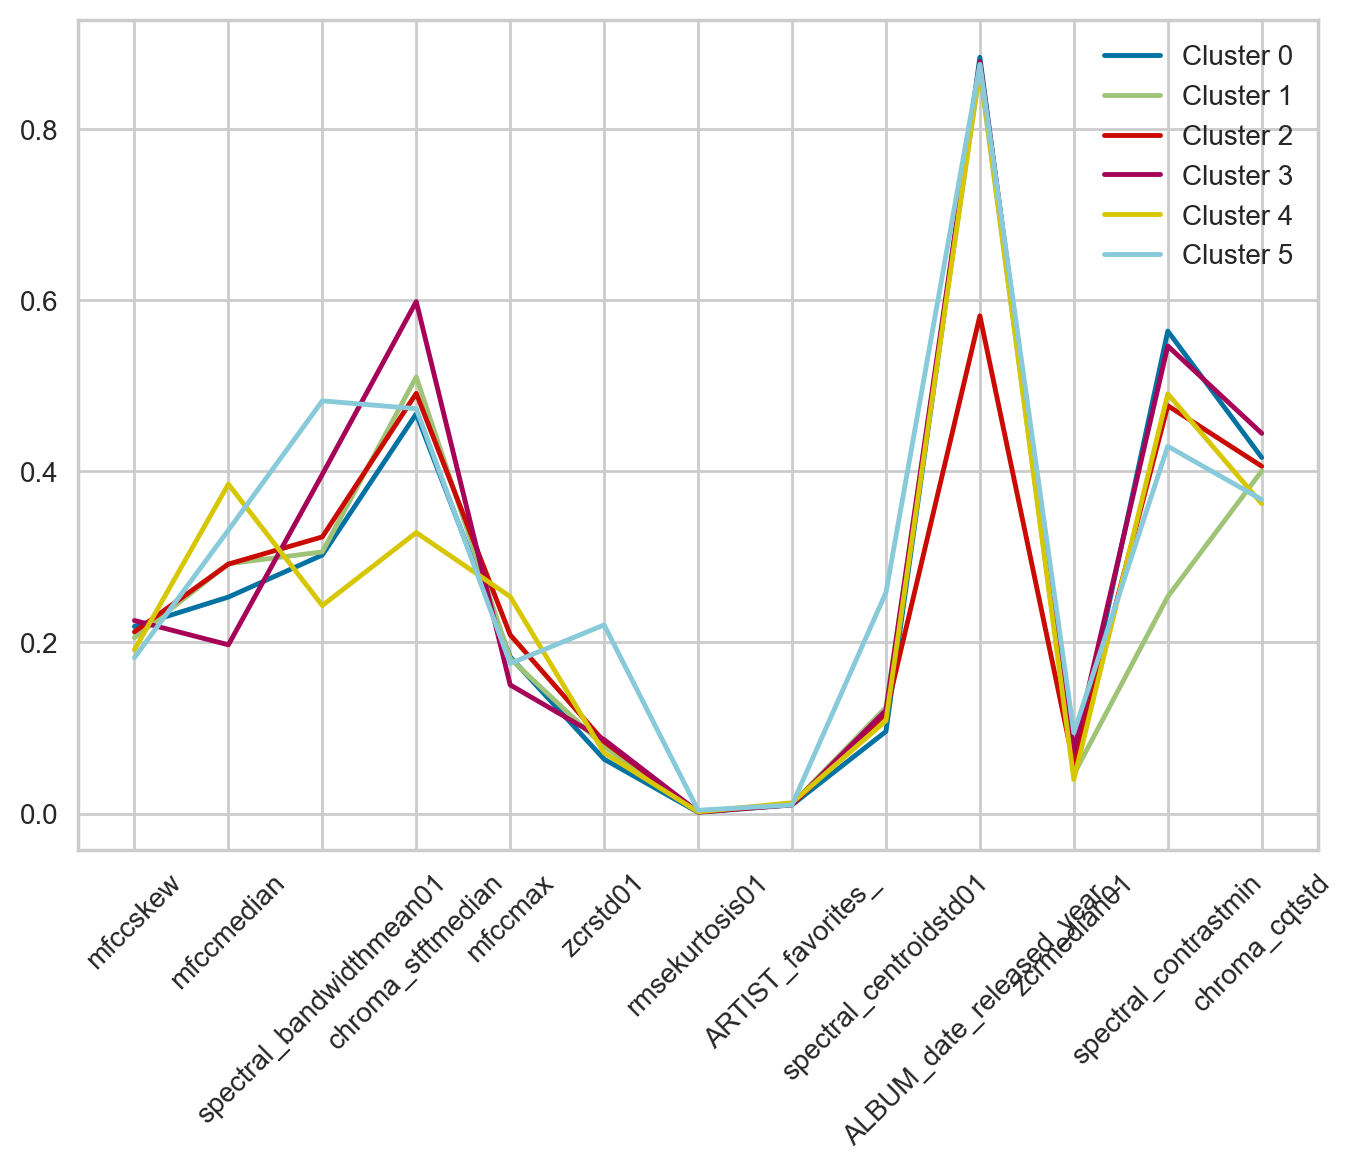

In [151]:
for idx, i in enumerate(model.cluster_centers_):
    plt.plot(i, label="Cluster "+str(idx))

plt.legend()
plt.xticks(range(13), attributi, rotation=45)

plt.savefig("kmeans_cluster_centers.pdf", bbox_inches="tight")

In [136]:
metrics.silhouette_score(X_scaled, model.labels_)

0.13027442158416597

# X-means

In [138]:
from pyclustering.cluster import xmeans

In [139]:
xm = xmeans.xmeans(X_scaled, kmax=20) #ne trova 70
xm.process()

In [140]:
clusters = xm.get_clusters()
centers = xm.get_centers()

len(centers)

20

In [142]:
xm.get_total_wce()

940.13054760545

In [143]:
np.array(clusters)

def label(index):
    for pos, i in enumerate(clusters):
        if index in i:
            return pos
    
    return -1 #canzone tolta dall'under sampler
tmp = []

for index in range(len(df.index)):
    tmp.append(label(index))
    
df['cluster'] = tmp

<ipython-input-143-ed8c2e9d286e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(clusters)


In [146]:
metrics.silhouette_score(X_scaled, tmp)

0.07789624391237593

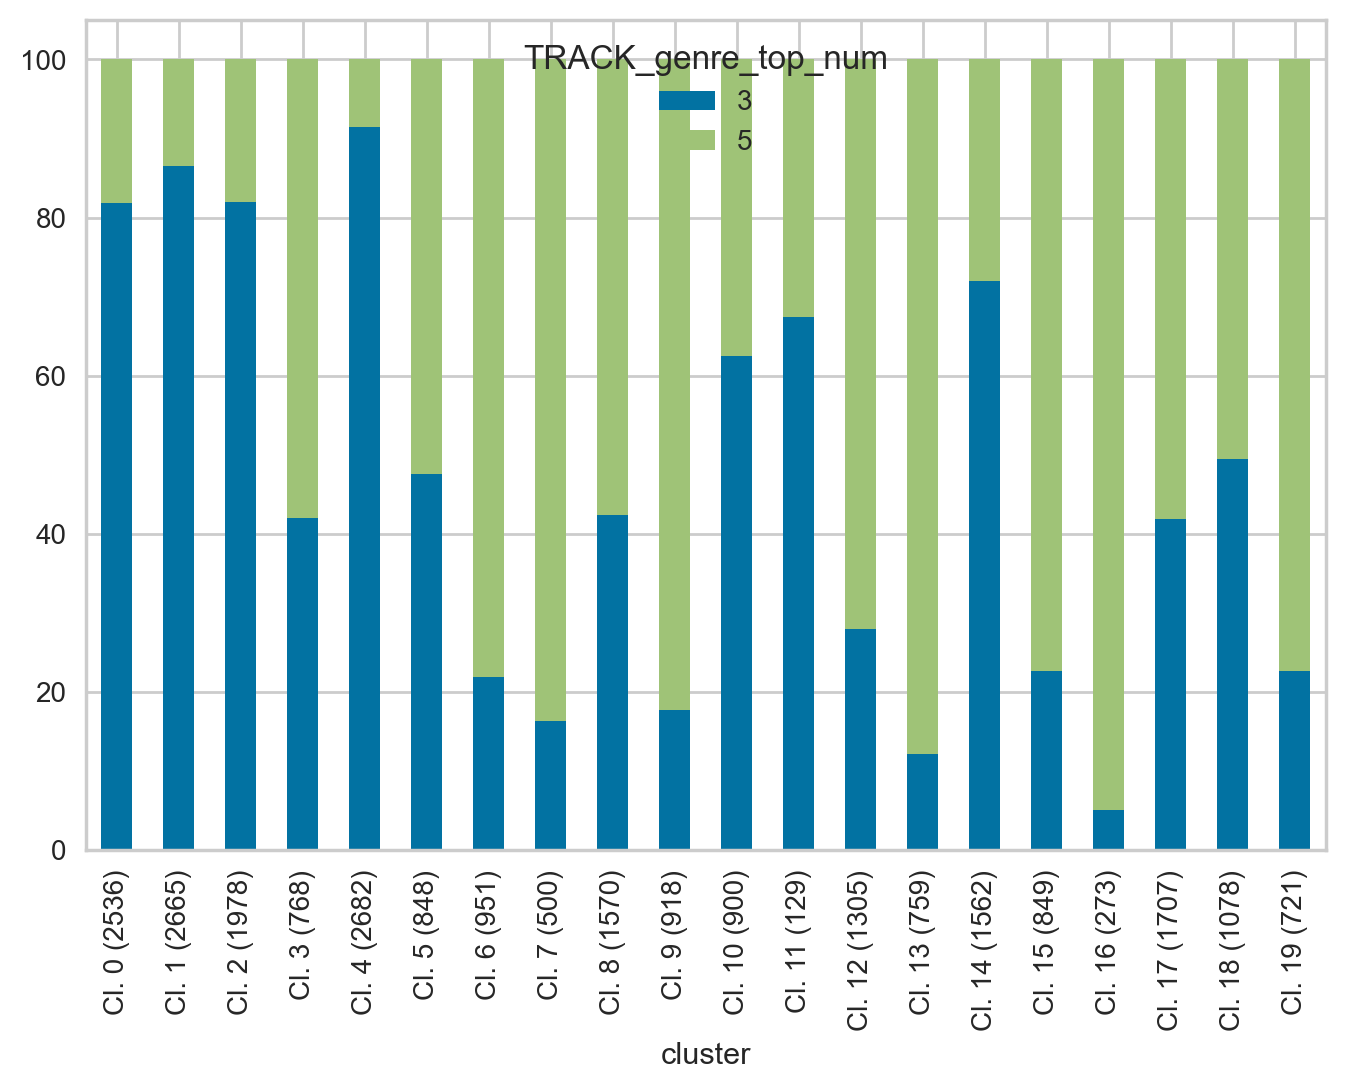

In [147]:
xlabels = []

for idx, i in enumerate(list(df.groupby('cluster').size())):
    xlabels.append("Cl. "+ str(idx)+" ("+str(i)+")")
    
xlabels


df.groupby(['cluster',class_name]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.xticks(range(len(xlabels)), xlabels, rotation=90)

plt.savefig("xmeans_cluster_perc.pdf", bbox_inches="tight")

AttributeError: module 'matplotlib.pyplot' has no attribute 'autofmt_xdate'

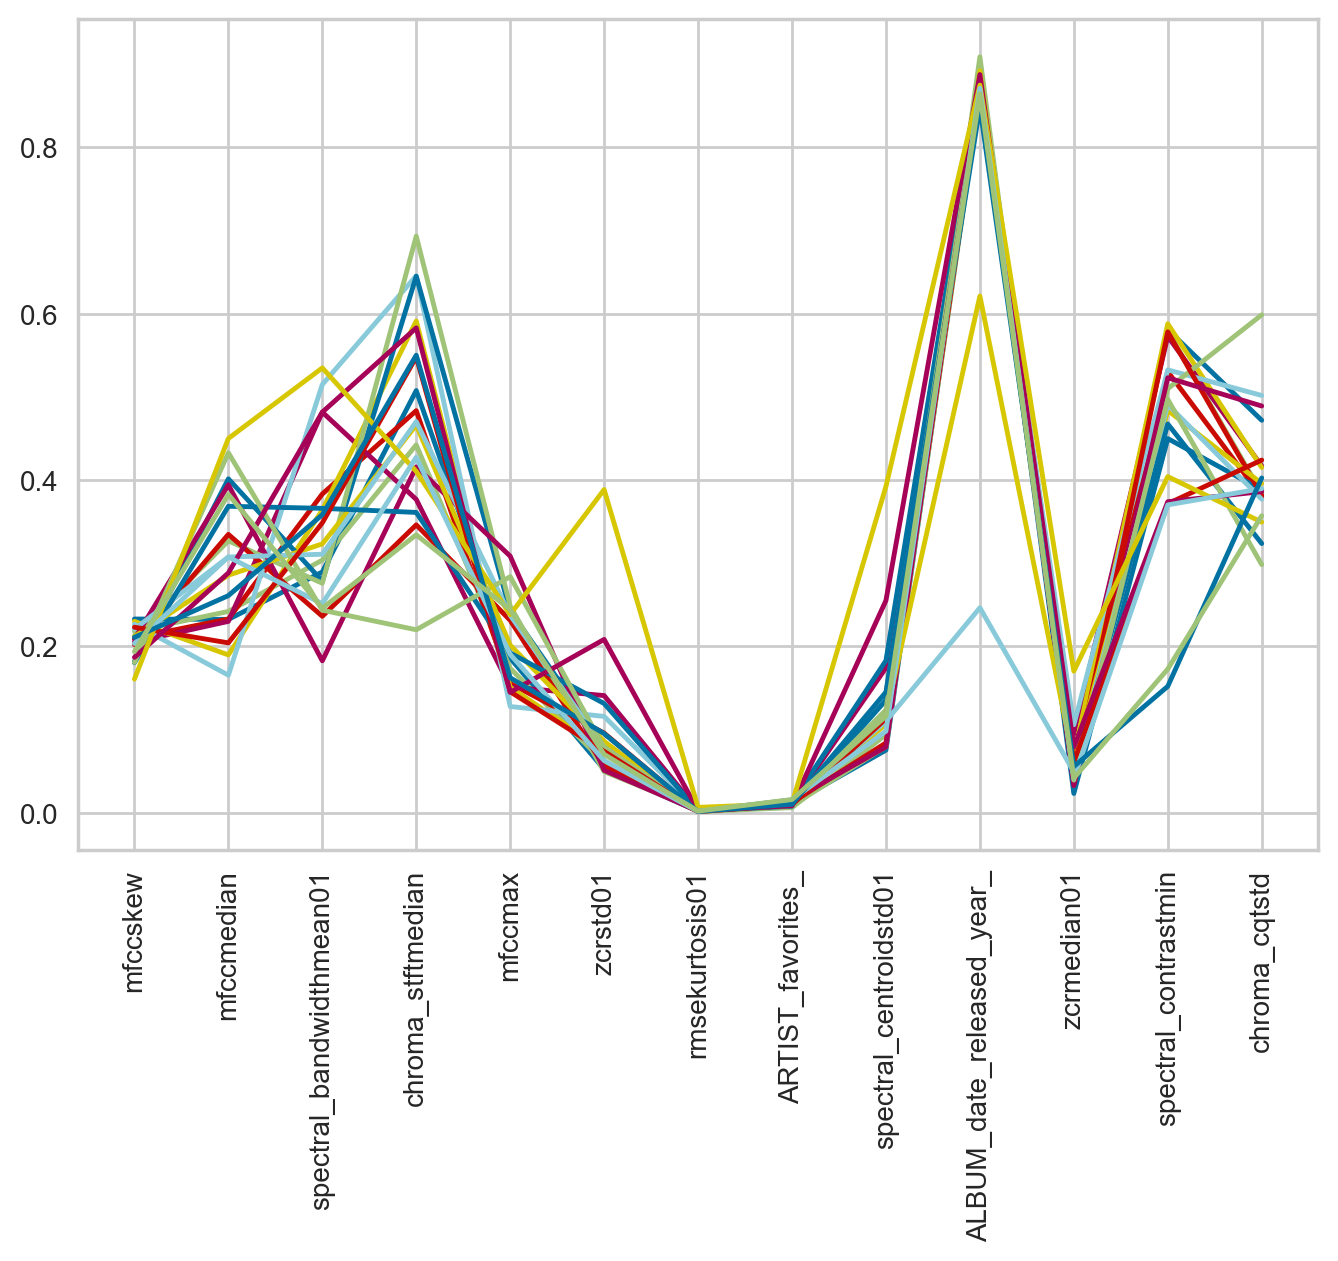

In [150]:
for idx, i in enumerate(xm.get_centers()):
    plt.plot(i, label="Cluster "+str(idx))

#plt.legend()
plt.xticks(range(13), attributi, rotation=90)

plt.autofmt_xdate()

plt.savefig("xmeans_cluster_centers.pdf", bbox_inches="tight")

# OPTICS

In [26]:
from sklearn.cluster import OPTICS

In [27]:
optics = OPTICS(min_samples=3, max_eps=np.inf, n_jobs=-1)
optics.fit(X_scaled)

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(min_samples=3, n_jobs=-1)

In [33]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_scaled[optics.labels_ != -1], optics.labels_[optics.labels_ != -1]))

Silhouette Coefficient: 0.342


In [34]:
len(optics.labels_[optics.labels_ != -1])

3720

In [35]:
len(optics.labels_)

24699

In [36]:
np.unique(optics.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


2
9793
3987
0.30195342412903425


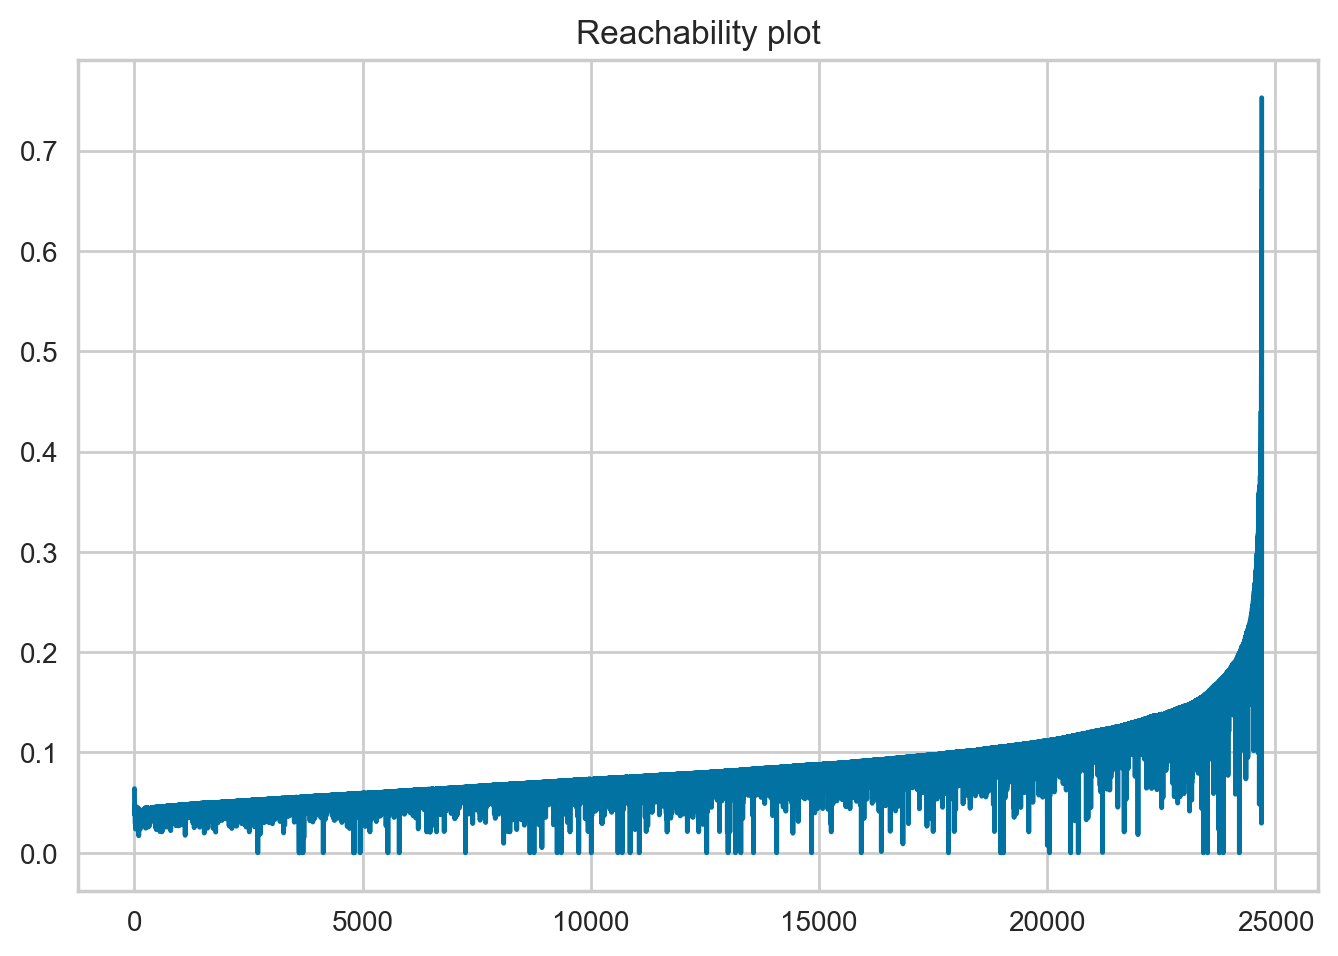

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


4
1762
315
0.3989642710345683


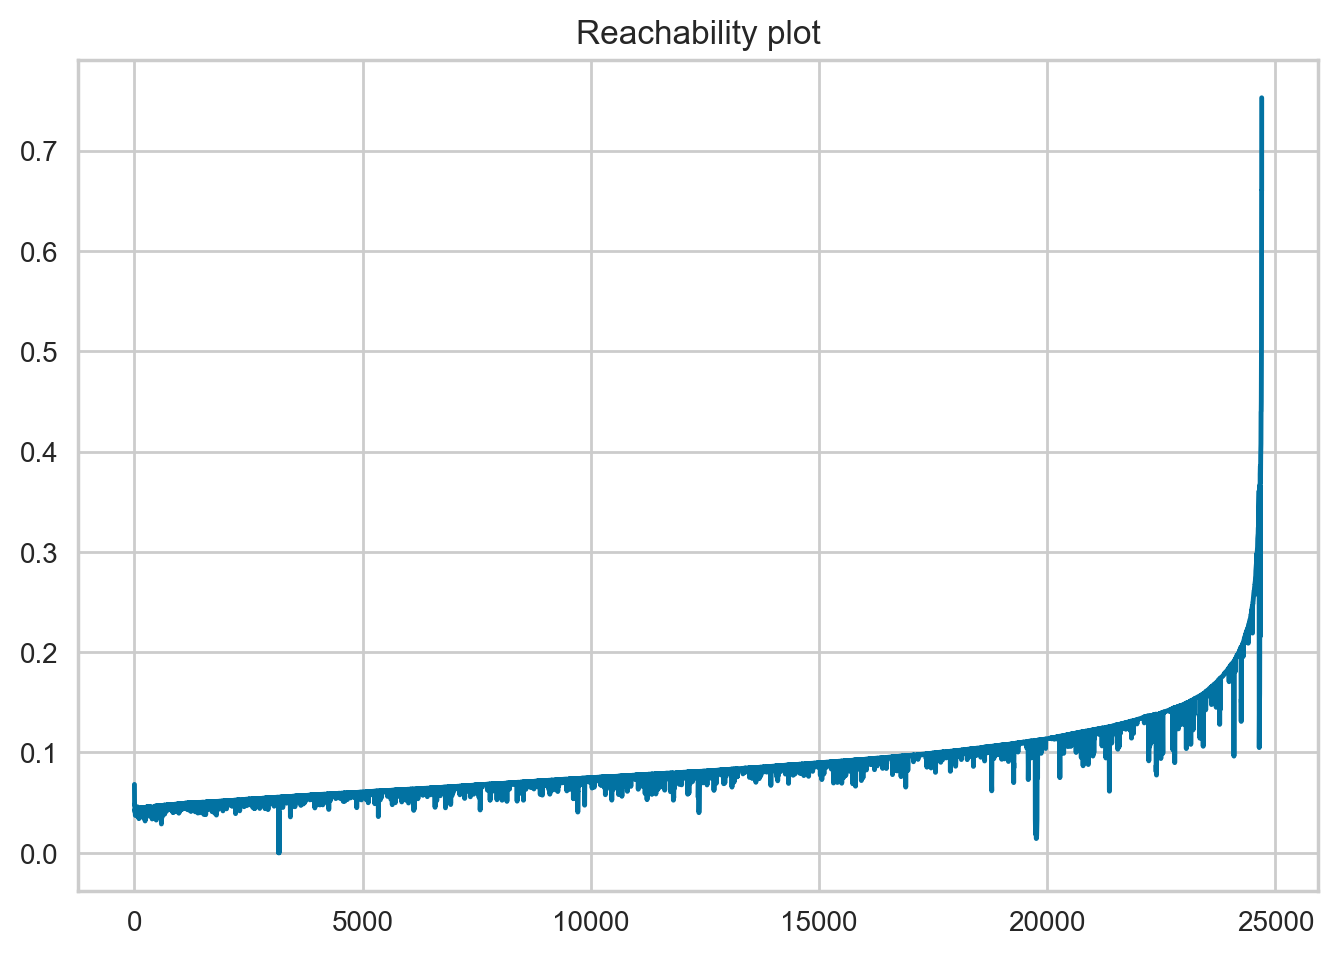

6
509
62
0.5177226384977939


C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


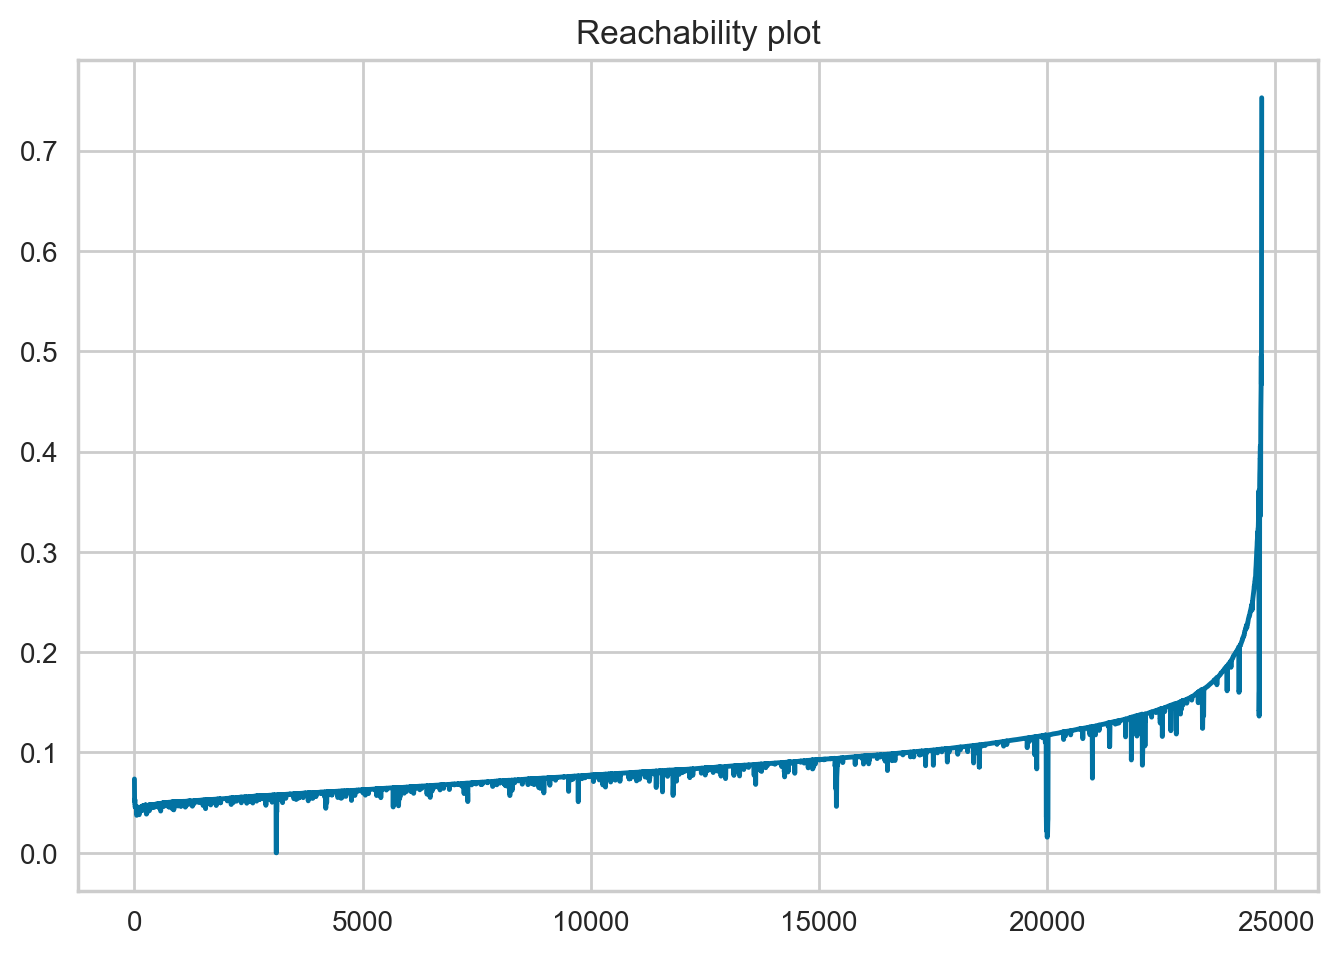

8
225
21
0.5892573222795117


C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


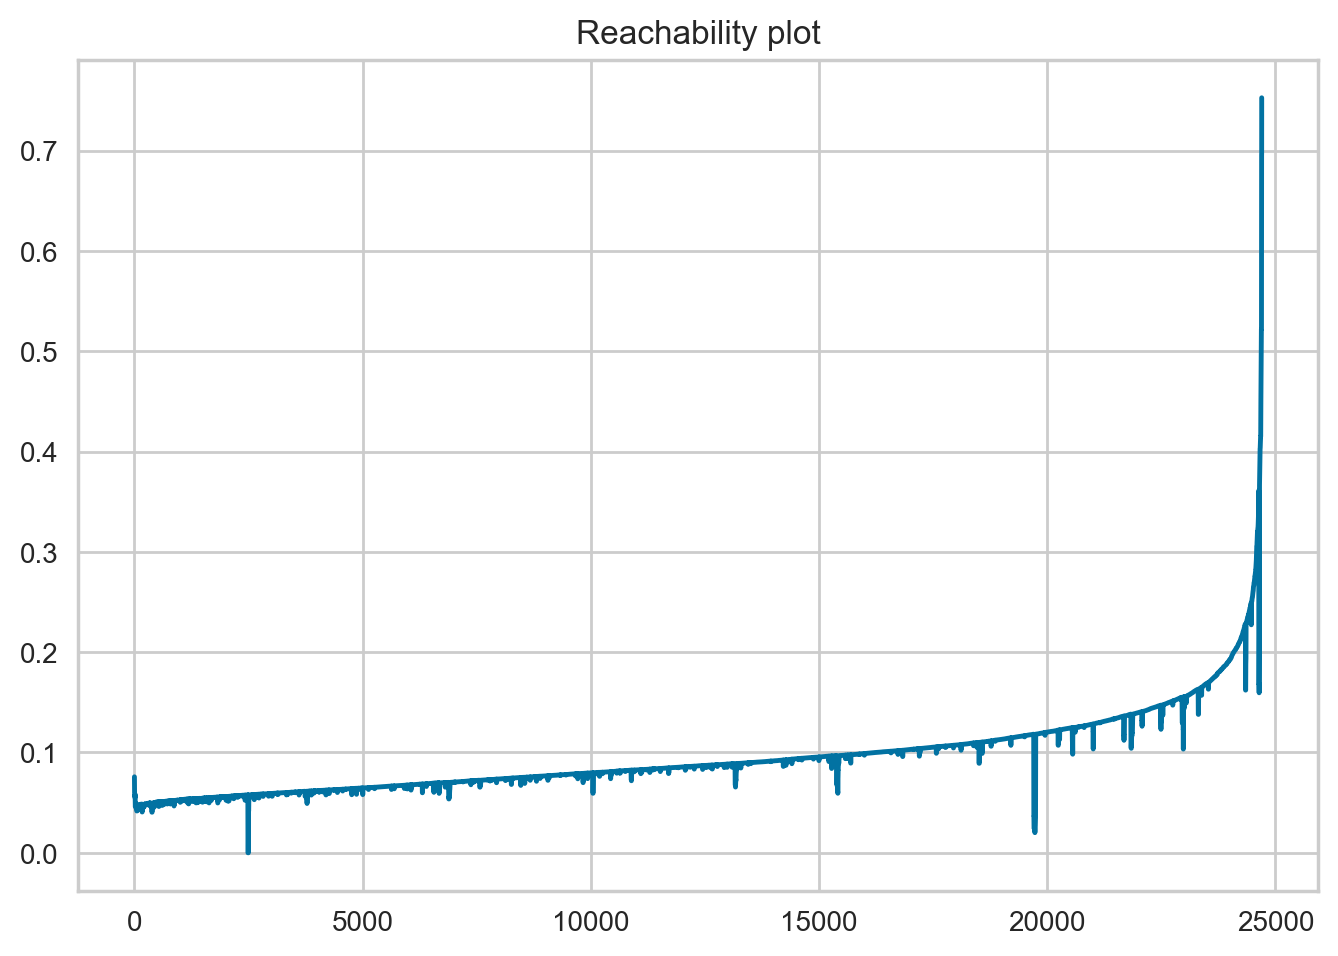

10
109
9
0.7105683647269438


C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


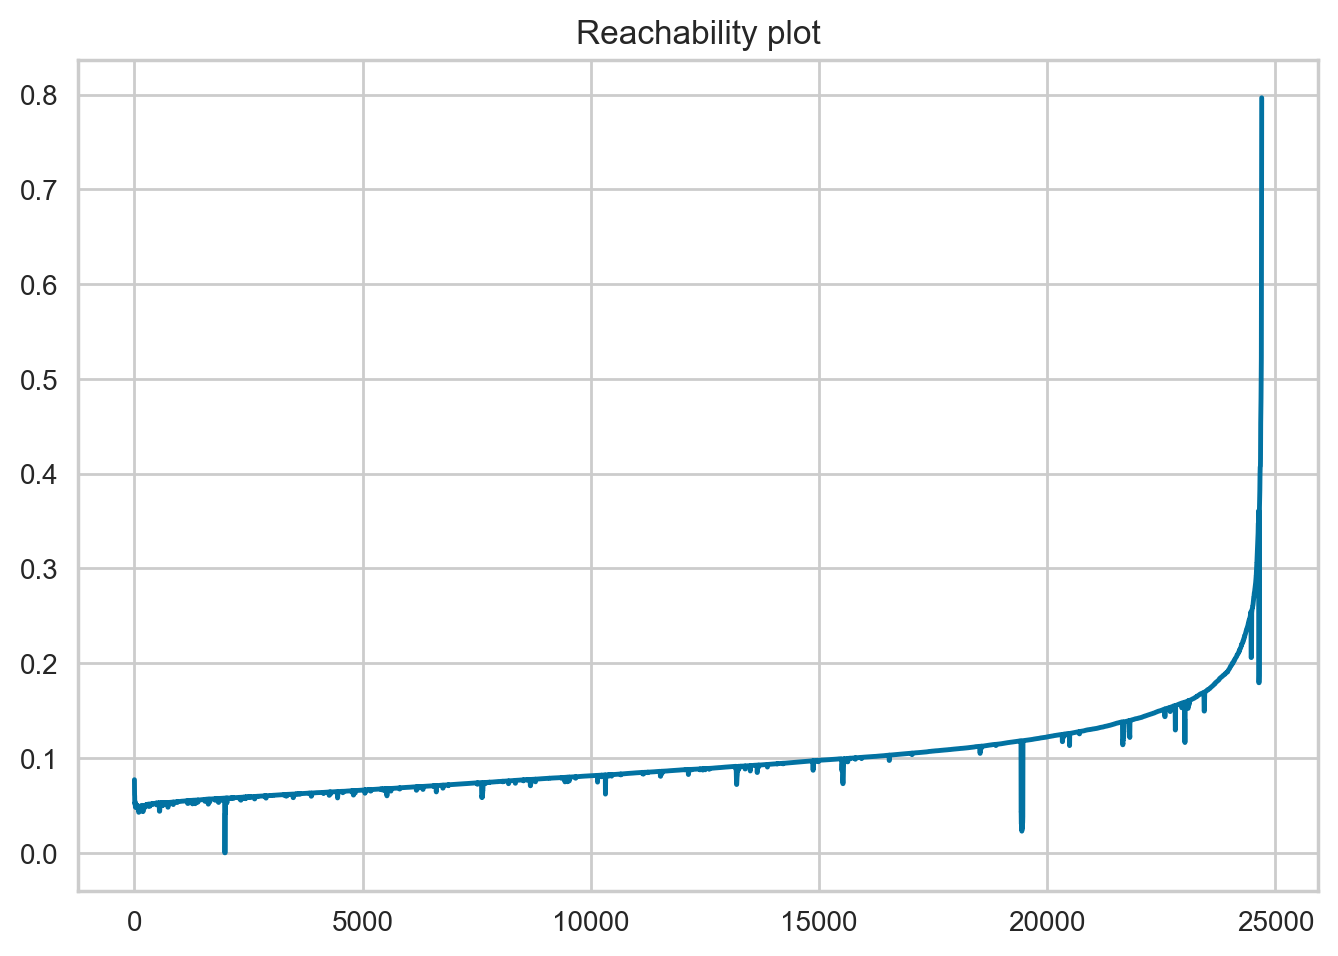

12
106
6
0.7461305216450625


C:\Users\cri98\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


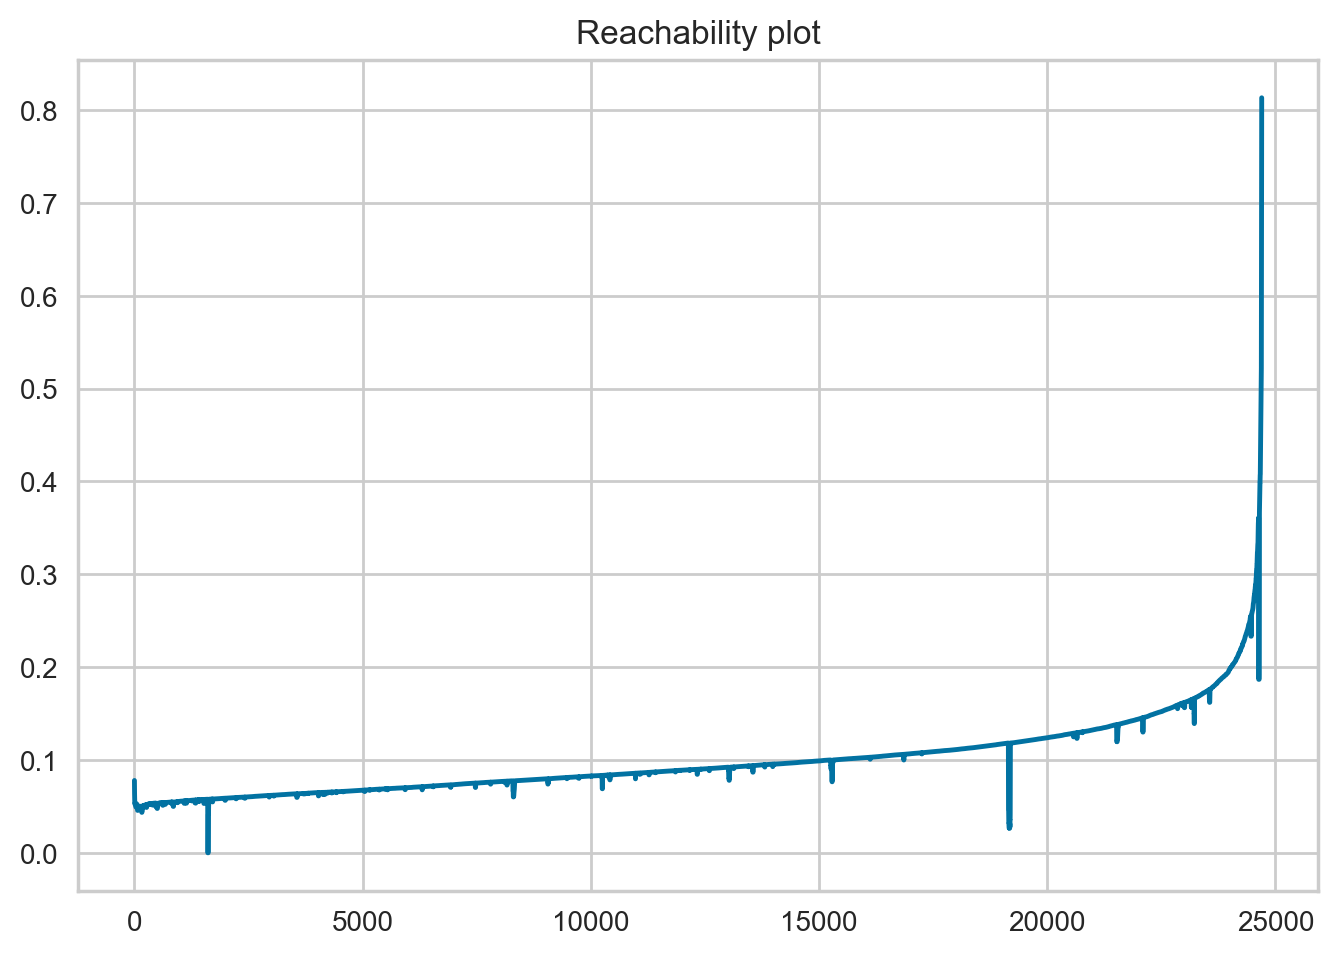

14
80
4
0.8334515164260885


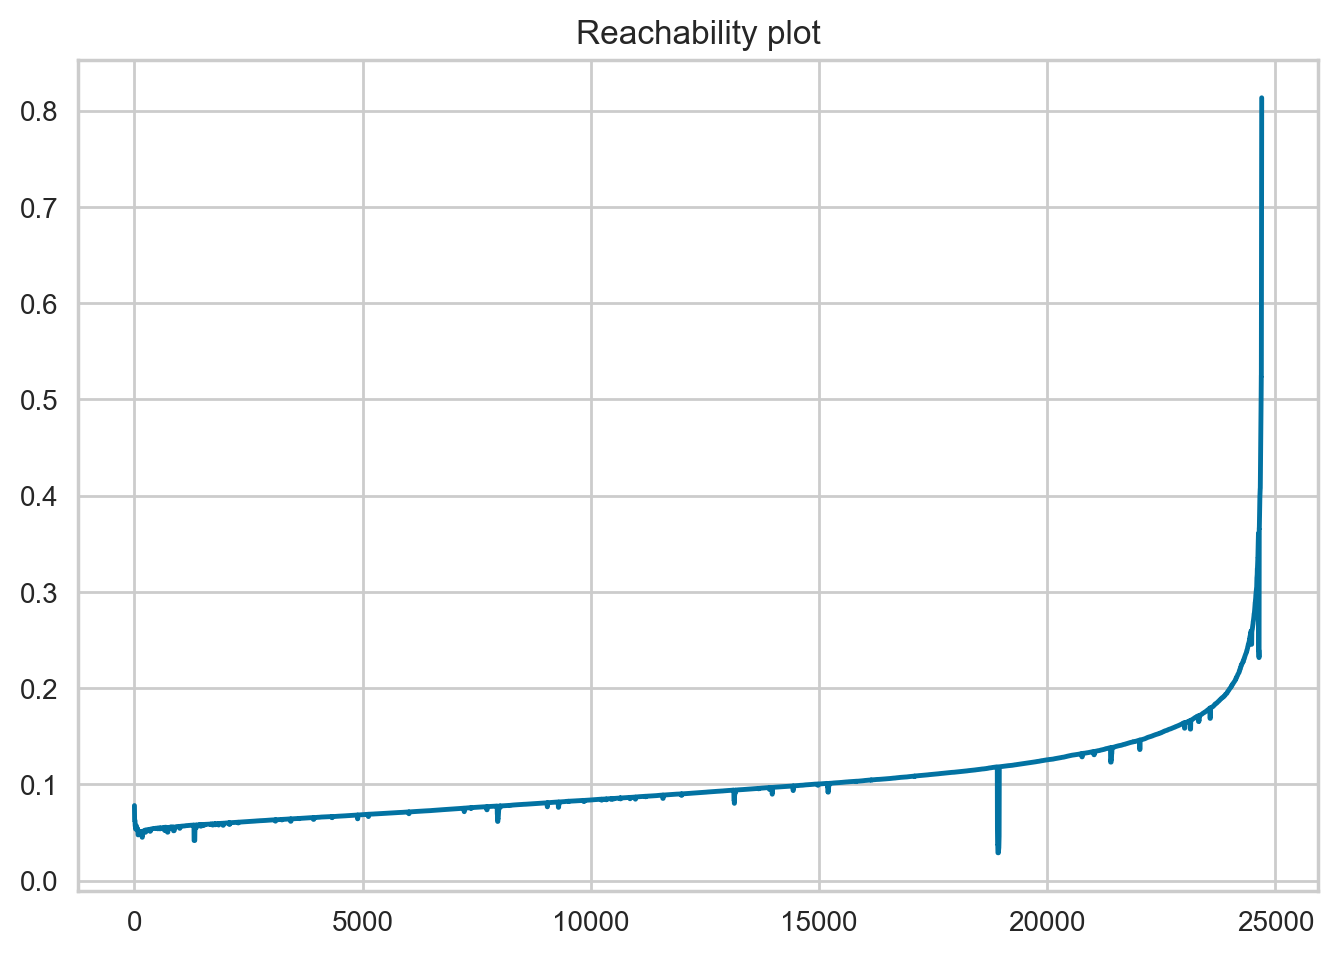

16
65
3
0.8456981297487359


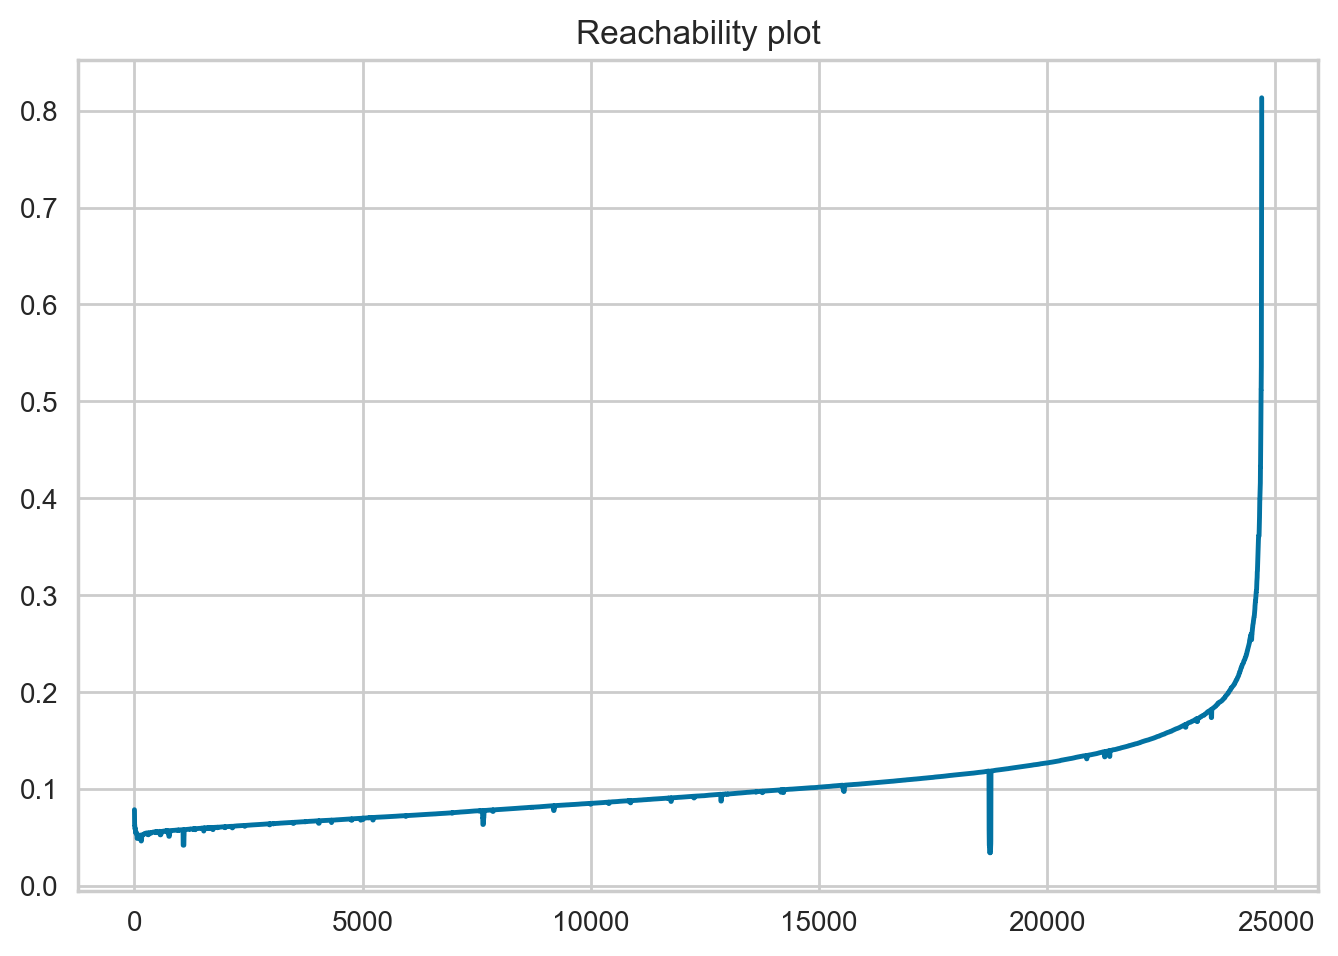

18
61
3
0.8523745856203567


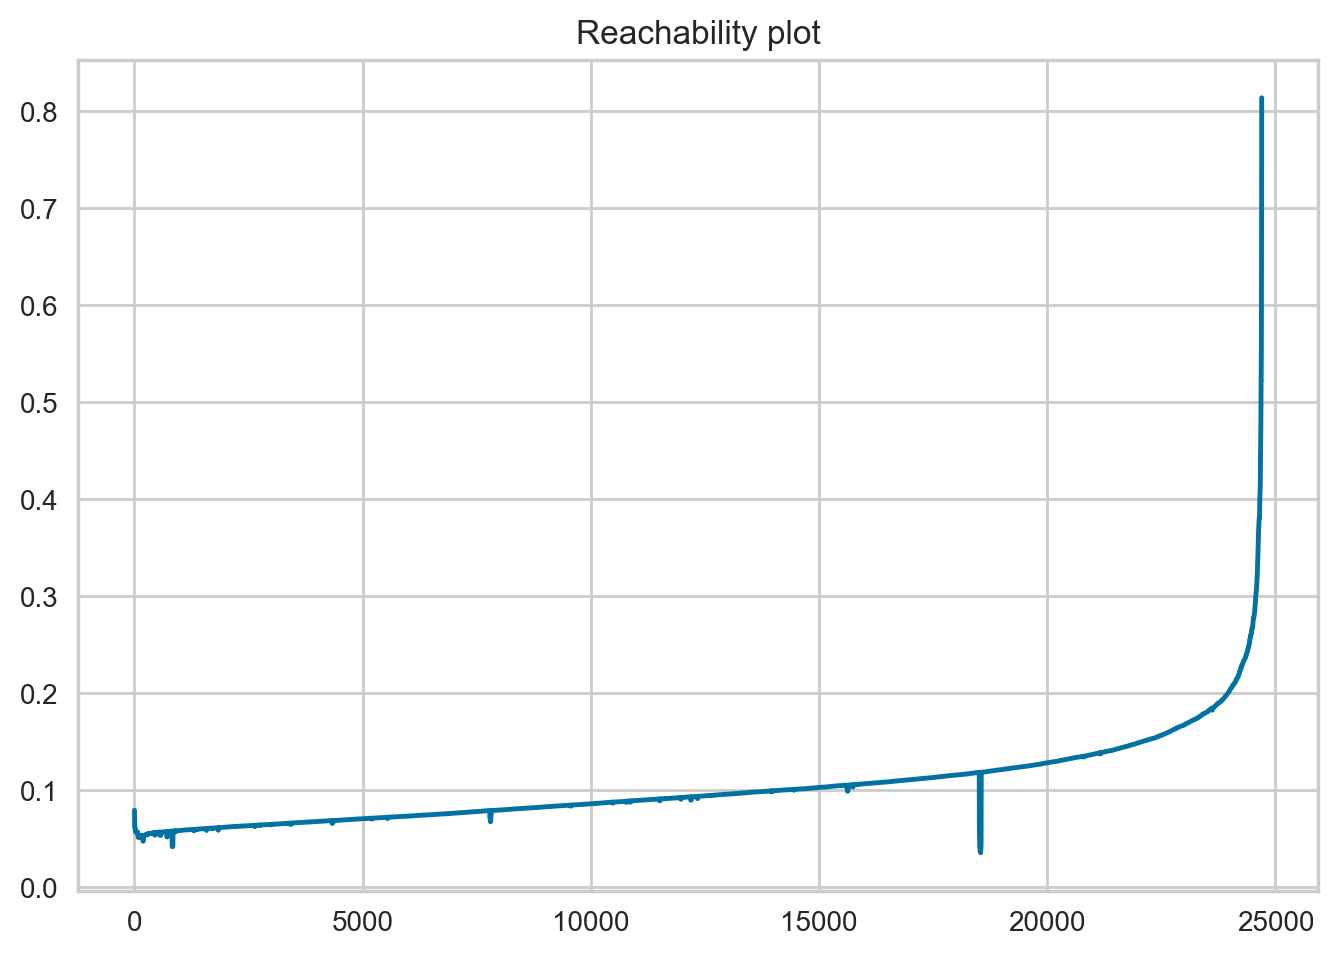

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [40]:
min_s = range(2, 30, 2) # 125 --> 0.9812072665572572

ris = {}

for i in tqdm(min_s):
    optics = OPTICS(min_samples=i, max_eps=np.inf, n_jobs=-1)
    optics.fit(X_scaled)
    
    ris[i] = metrics.silhouette_score(X_scaled[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])
    
    print(i)
    print(len(optics.labels_[optics.labels_ != -1]))
    print(len(np.unique(optics.labels_)))
    print(ris[i])
    reachability = optics.reachability_[optics.ordering_]

    plt.plot(reachability)
    plt.title('Reachability plot')
    plt.show()
    
ris

In [321]:
lst1 = {2: 14814,
 3: 8522,
 4: 5160,
 5: 3442,
 6: 2181,
 7: 1547,
 8: 1138,
 9: 709}

In [335]:
list(map(lambda x: x/24699, list(lst1.values())))

[0.5997813676667072,
 0.3450342119114134,
 0.20891534070205273,
 0.13935786873962508,
 0.08830317016883274,
 0.06263411474148751,
 0.04607473986801085,
 0.028705615611968095]

([<matplotlib.axis.XTick at 0x25328919d00>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9')])

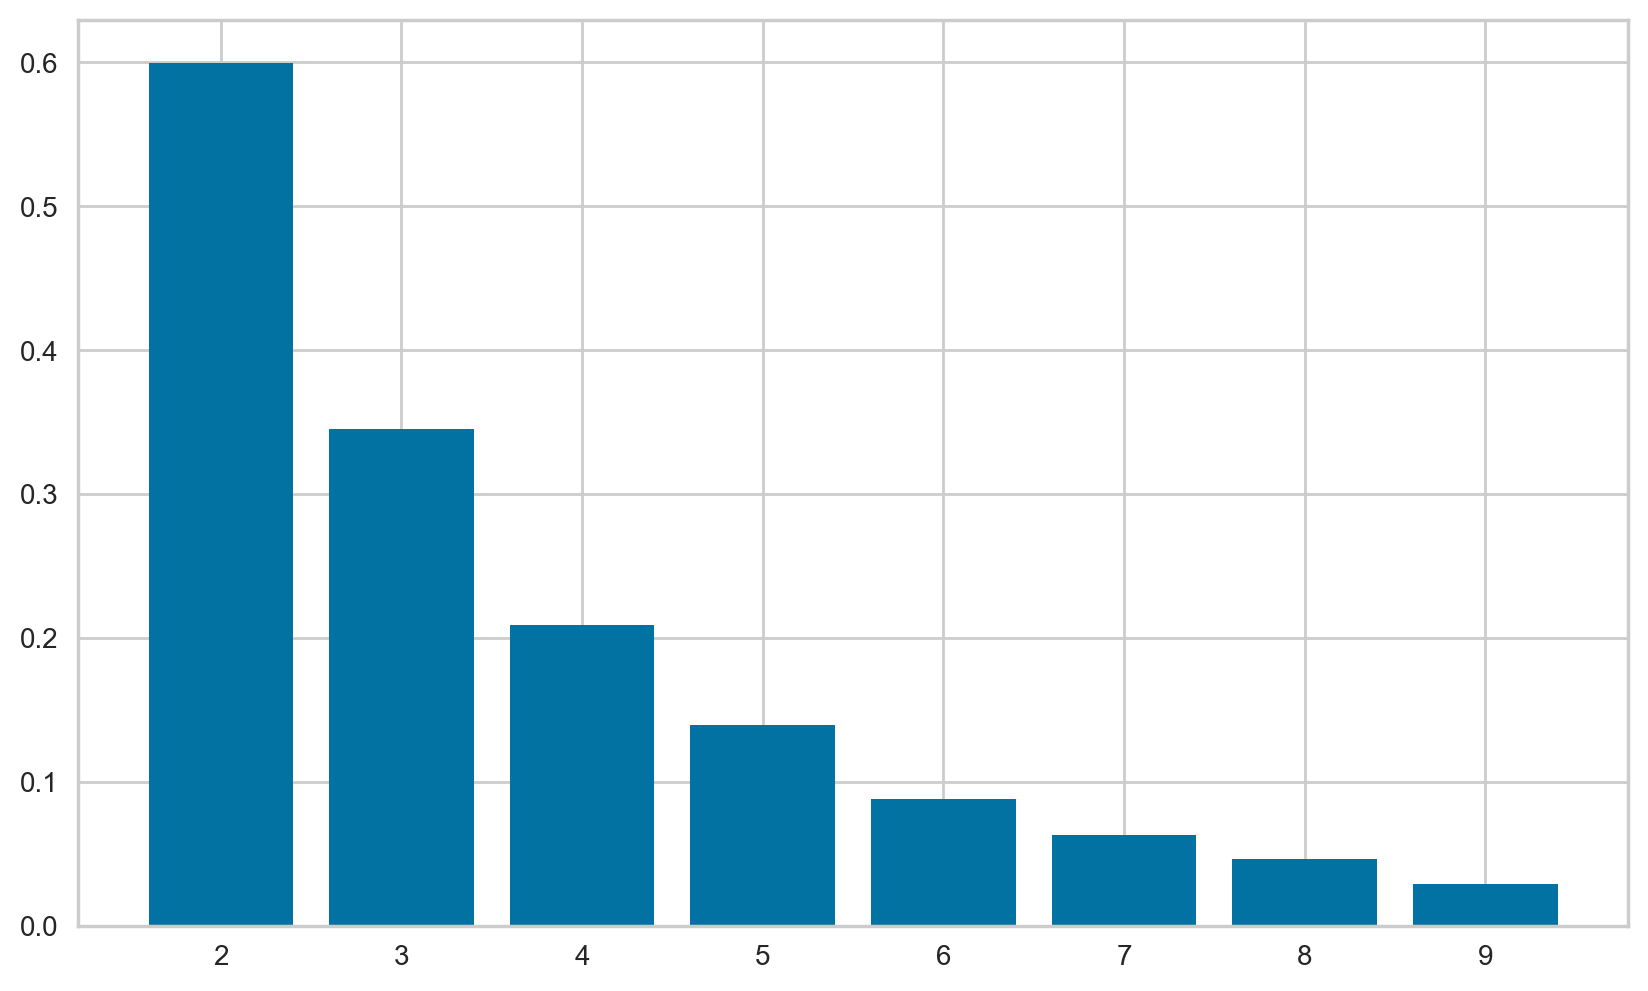

In [336]:
plt.bar(range(len(lst1)), list(map(lambda x: x/24699, list(lst1.values()))), align='center')
plt.xticks(range(len(lst1)), list(lst1.keys()))

([<matplotlib.axis.XTick at 0x253451554f0>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9')])

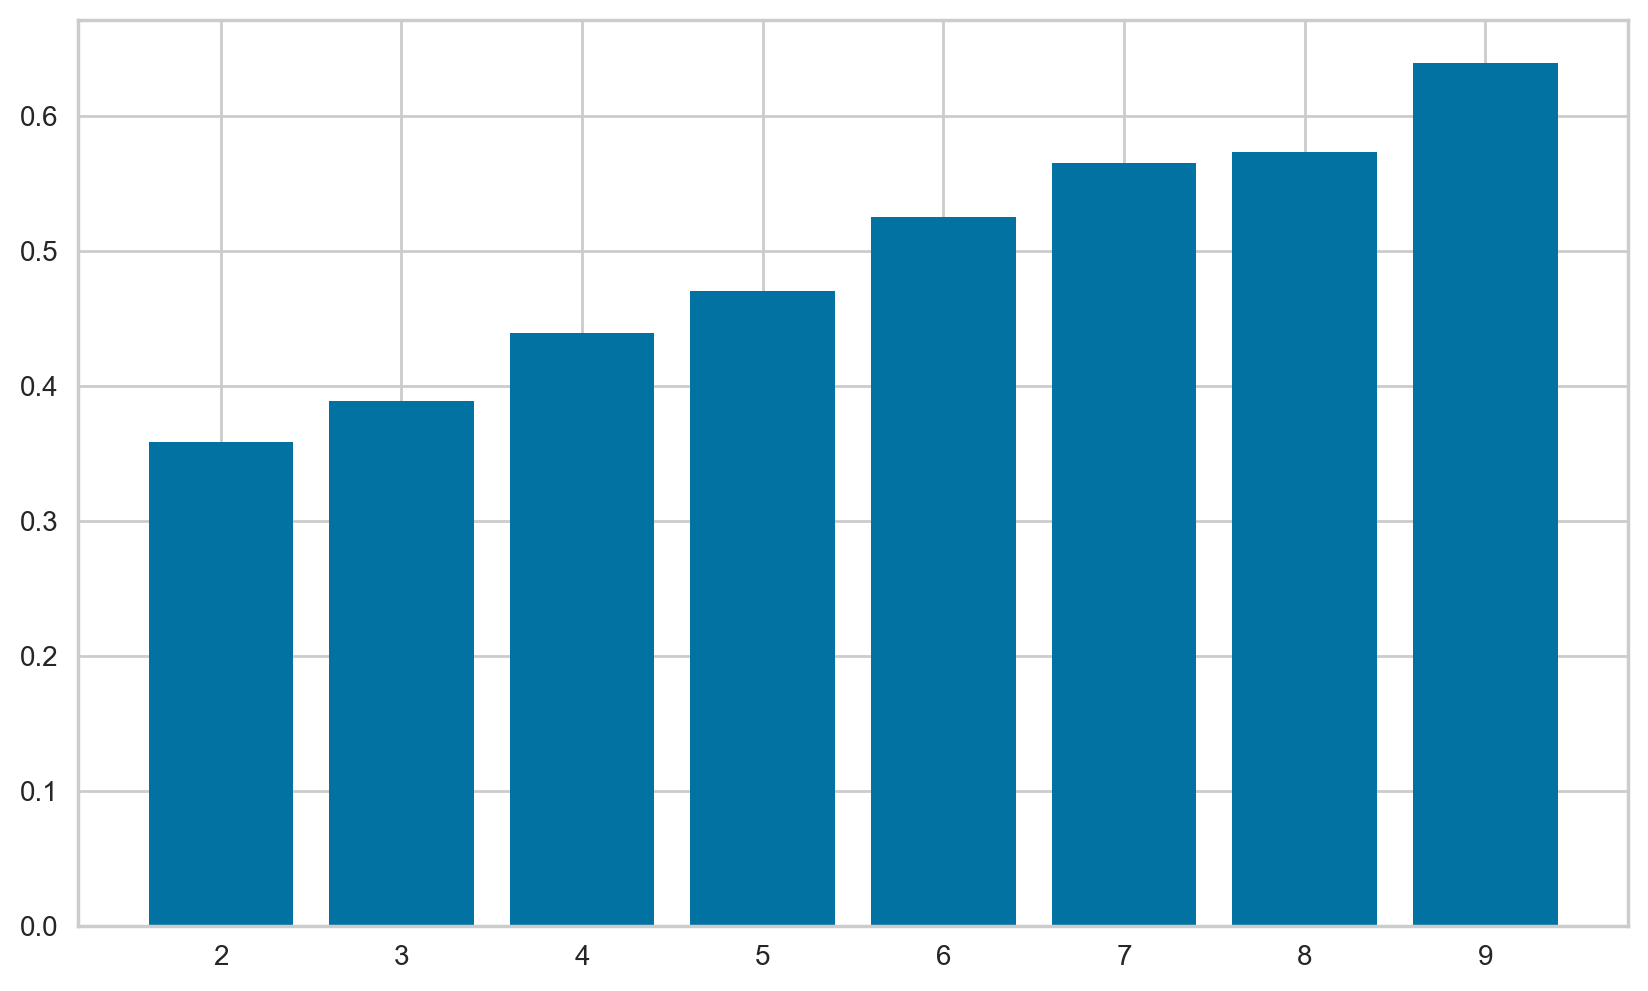

In [328]:
lst2= {2: 0.35814238998086134,
 3: 0.38825102015628277,
 4: 0.43879588281675724,
 5: 0.46984568070556326,
 6: 0.5250125000027013,
 7: 0.5646197736480506,
 8: 0.5729088013099415,
 9: 0.6392141651781436}

plt.bar(range(len(lst2)), list(lst2.values()), align='center')
plt.xticks(range(len(lst2)), list(lst2.keys()))

In [409]:
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

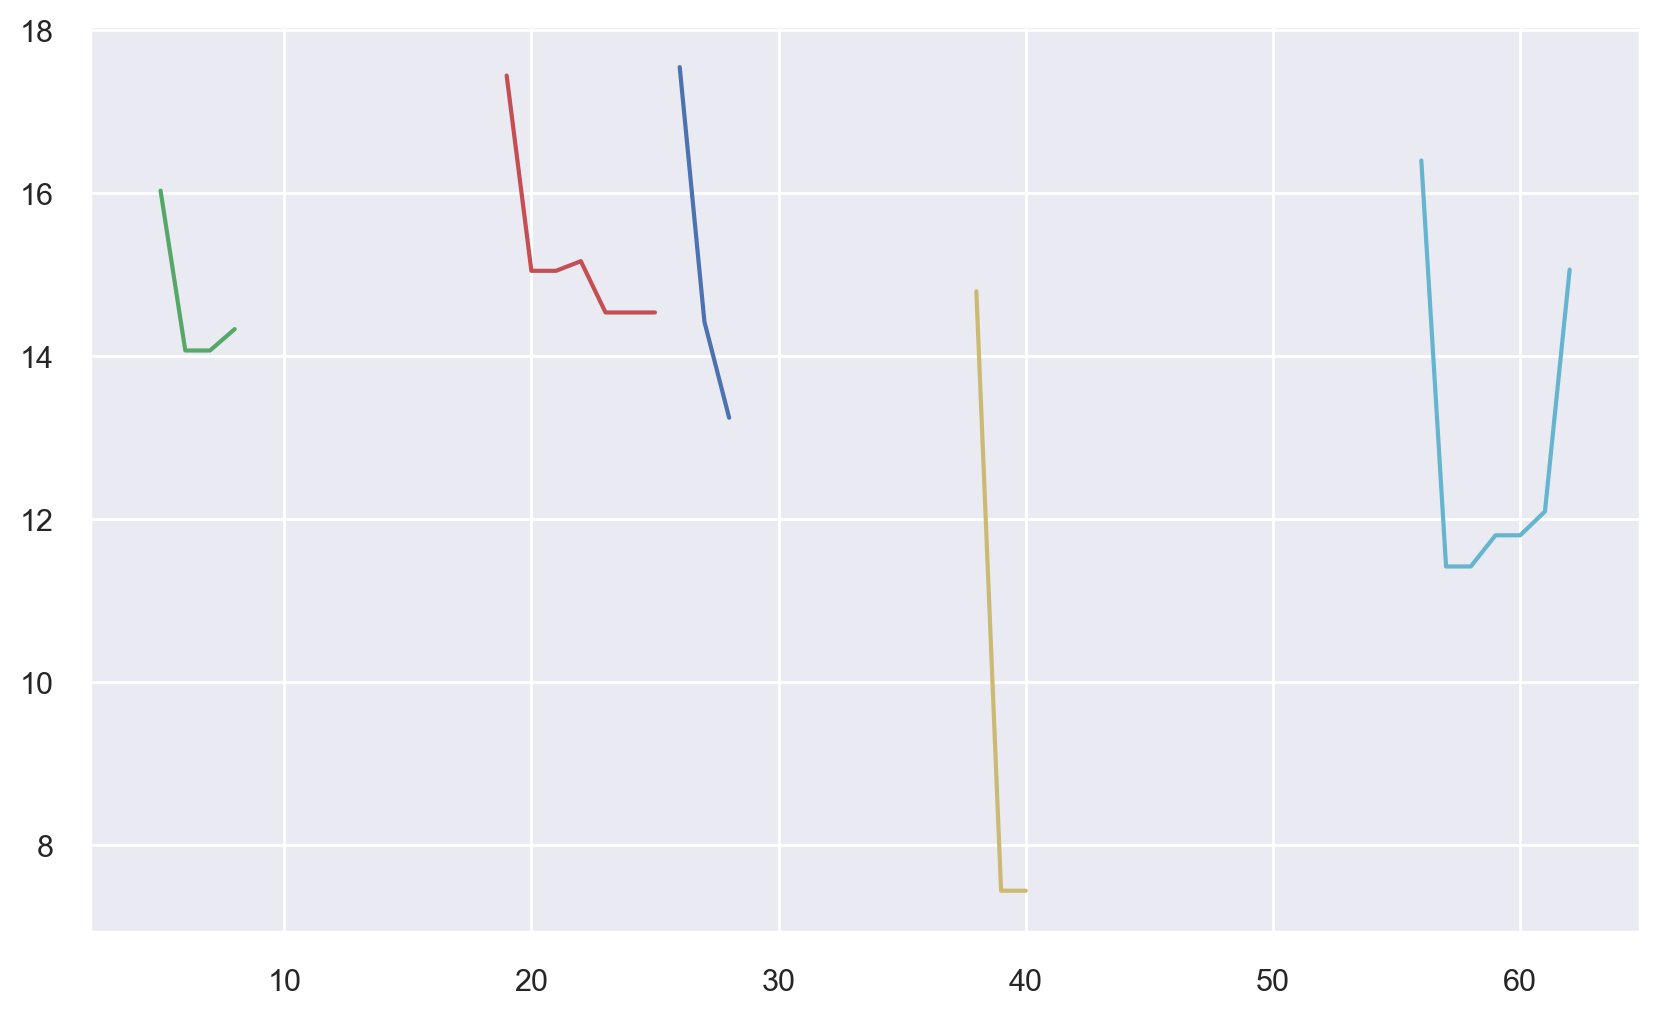

In [412]:
reachability = optics.reachability_[optics.ordering_]
space = np.arange(len(X))

colors = ['g-', 'r-', 'b-', 'y-', 'c-']
for klass, color in zip(range(0, 1956), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color)


#plt.plot(reachability, c='red')
#plt.title('Reachability plot')
plt.show()

Text(0.5, 1.0, 'Reachability Plot')

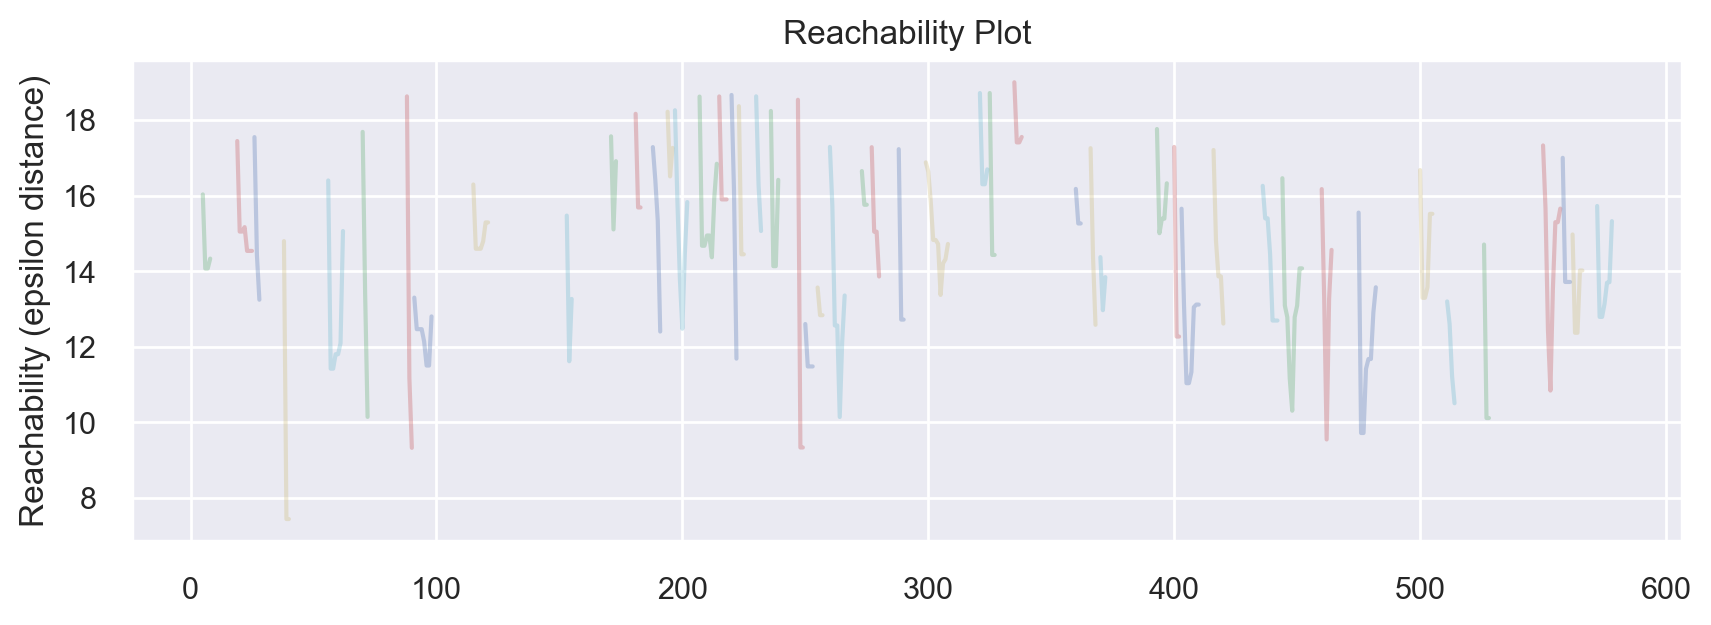

In [413]:
import matplotlib.gridspec as gridspec


plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])

# Reachability plot
colors = ['g-', 'r-', 'b-', 'y-', 'c-']
for klass in range(0, 50):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, colors[klass%5], alpha=0.3)
    
    
#ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
#ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
#ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

In [381]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.autumn
norm = Normalize(vmin=-1, vmax=60)


In [383]:
cmap.to_rgba(labels)

AttributeError: 'LinearSegmentedColormap' object has no attribute 'to_rgba'

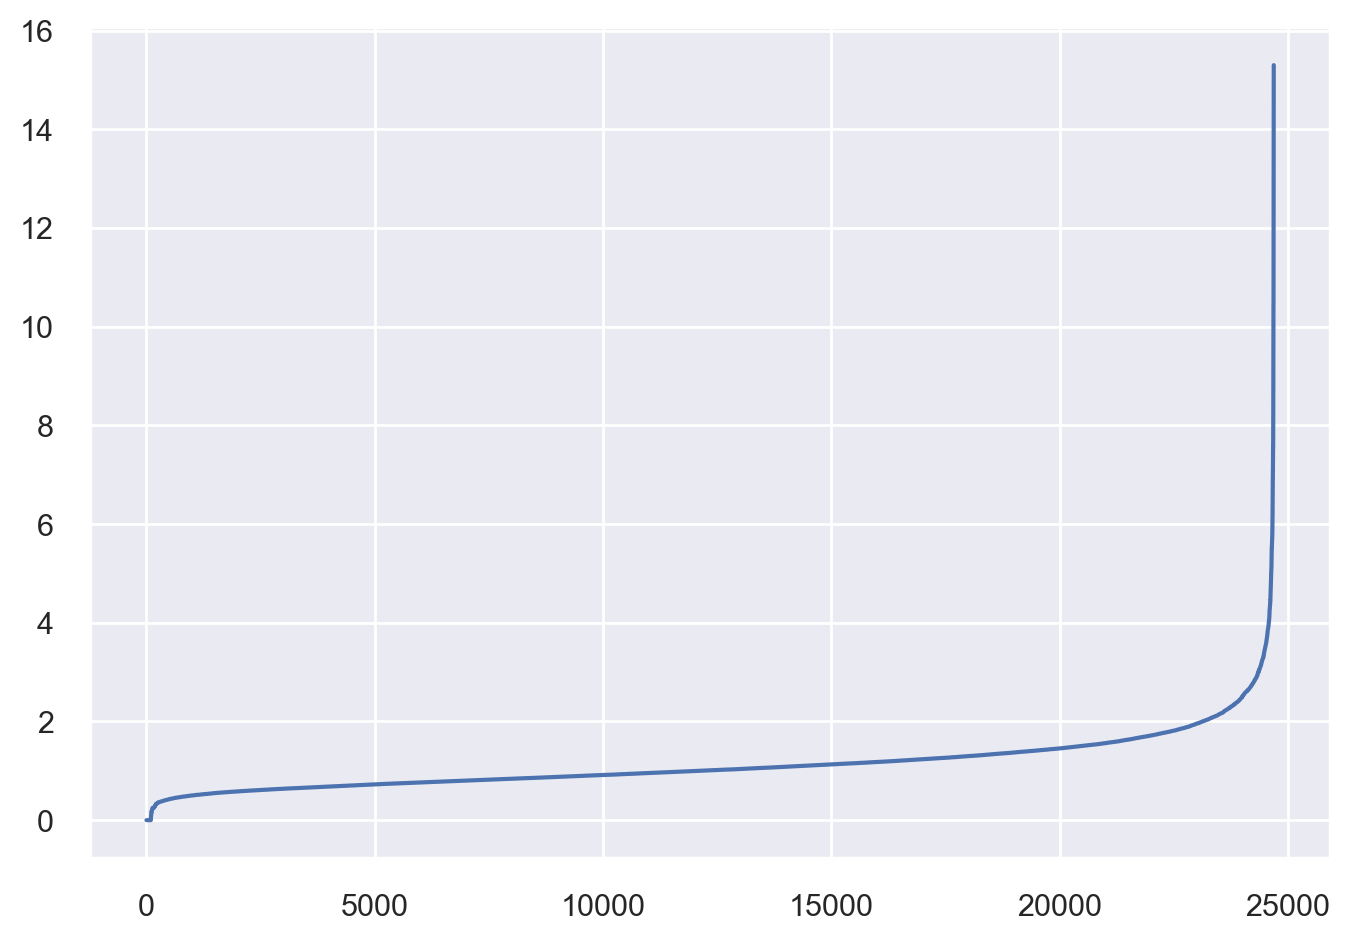

In [74]:
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

sns.set()


neigh = NearestNeighbors(n_neighbors=2*X_scaled.shape[1]) #https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.plot([2050 for x in range(len(distances))])
plt.plot(distances[:])

In [92]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=2*X_scaled.shape[1]).fit(X_scaled)

In [93]:
df['DBSCAN'] = clustering.labels_


<AxesSubplot:xlabel='DBSCAN'>

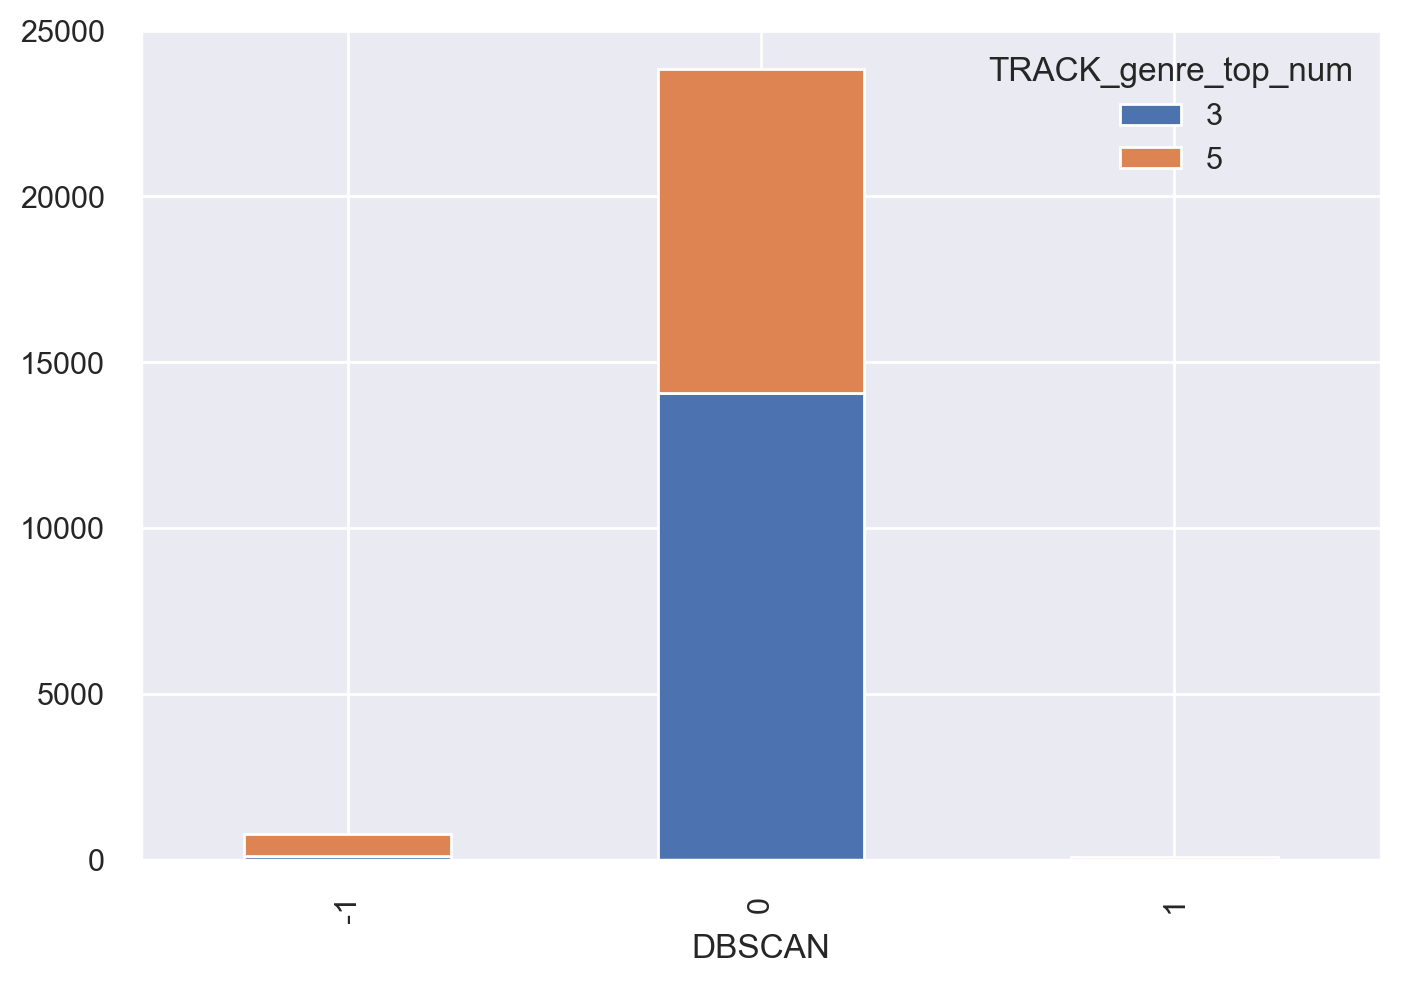

In [94]:
df.groupby(['DBSCAN',class_name]).size().unstack().plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='DBSCAN'>

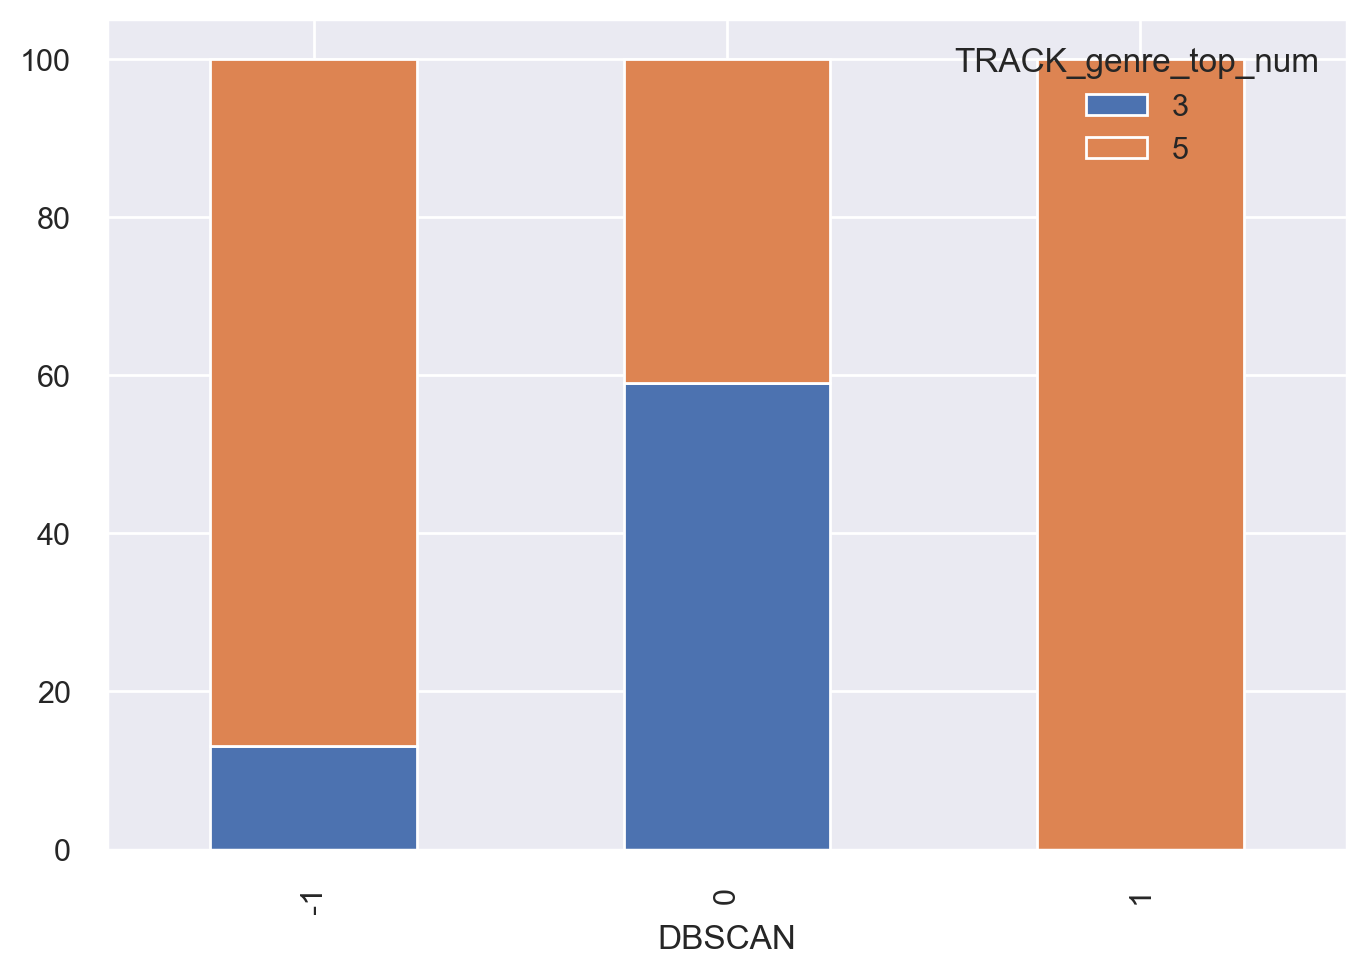

In [95]:
df.groupby(['DBSCAN',class_name]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)